# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
#data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

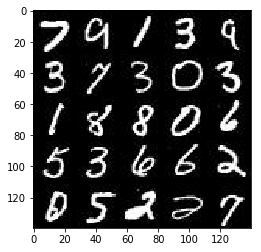

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

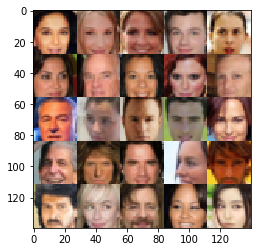

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'): 
    return tf.maximum(x, alpha * x, name=name)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    rate = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.dropout(x1, rate)
        relu1 = leaky_relu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        # 7x7x256
        
    

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    rate = 0.5
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.dropout(x2, rate, training=is_train)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.dropout(x3, rate, training=is_train)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.dropout(x4, rate, training=is_train)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Set channel width
    if data_image_mode == "RGB":
        image_channels = 3
    else:
        image_channels = 1
        
    # Set data shape
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    # run g_train_opt twice
    _, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Normalize image to -1, 1
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # Run generator twice
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if (steps % print_every == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                
                if (steps % show_every == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.1735
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 2.7305
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 2.0269
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.9898
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.7283
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 1.1310


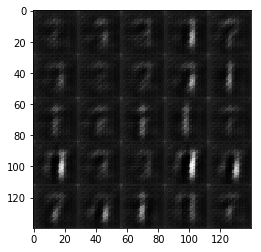

Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 1.7442
Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 1.6618
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 2.2057
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 3.8298
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.9693
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 3.9540
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 1.7655
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.4142


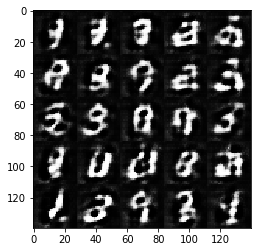

Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 1.8602
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.7954
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.6335
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.1801
Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 1.6817


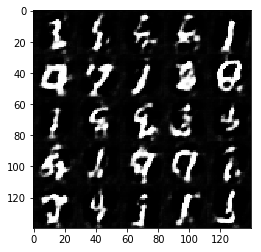

Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 2.1404
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.3061
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.4902
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 1.4749
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 2.4001
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 1.9086
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.5129
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 2.1623
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5545


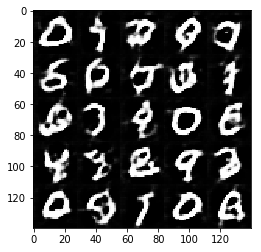

Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.7831
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.5899
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 1.6374
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 2.3291
Epoch 1/2... Discriminator Loss: 5.2823... Generator Loss: 5.9690
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 1.3760
Epoch 1/2... Discriminator Loss: 0.8827... Generator Loss: 1.4200
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 1.5454


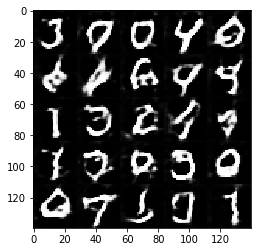

Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.4327
Epoch 1/2... Discriminator Loss: 0.7877... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.5408
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 0.6927... Generator Loss: 1.7918
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 2.6888
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.8305


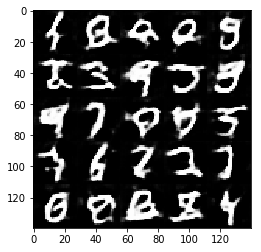

Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.7494
Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 1.8182
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 1.6476
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.3970
Epoch 1/2... Discriminator Loss: 1.6460... Generator Loss: 2.8300
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.6128
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.6903
Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.6759


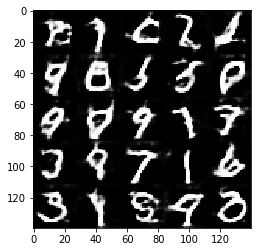

Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 2.3931
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 2.0723
Epoch 1/2... Discriminator Loss: 0.6962... Generator Loss: 1.7030
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 1.7471
Epoch 1/2... Discriminator Loss: 0.6161... Generator Loss: 1.9811
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.3706
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.3987
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.8823


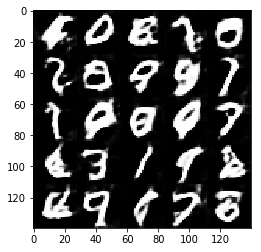

Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 2.4614
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 1.9087
Epoch 1/2... Discriminator Loss: 3.4392... Generator Loss: 5.7503
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 1.4994
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.7959
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 2.7351
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.3989
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 1.8982


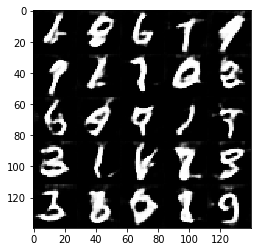

Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 2.0496
Epoch 1/2... Discriminator Loss: 0.5583... Generator Loss: 2.0145
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 2.0407
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 1.0223
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.6561
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.9654
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 2.6941
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.6998


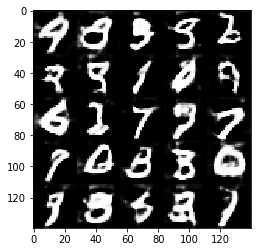

Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 2.5698
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 0.6709... Generator Loss: 1.3693
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.5894
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.8642
Epoch 2/2... Discriminator Loss: 0.5391... Generator Loss: 2.0187
Epoch 2/2... Discriminator Loss: 2.0680... Generator Loss: 0.3199
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.6264


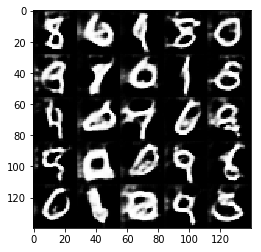

Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.2903
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.7680
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 2.9377
Epoch 2/2... Discriminator Loss: 0.6534... Generator Loss: 1.2013
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 2.5123
Epoch 2/2... Discriminator Loss: 1.7191... Generator Loss: 4.6230
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 2.8449


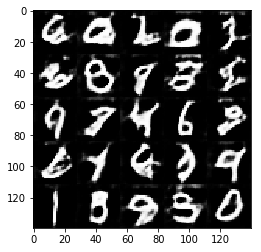

Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 2.5242
Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 2.2007
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 2.8309
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.5732
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.5949
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.8475
Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.4058


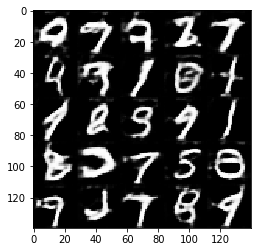

Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 0.9971
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 2.0969
Epoch 2/2... Discriminator Loss: 0.5459... Generator Loss: 1.9558
Epoch 2/2... Discriminator Loss: 0.8159... Generator Loss: 3.1951
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.4627
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.4180
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 2.1393
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.4991
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 3.6216


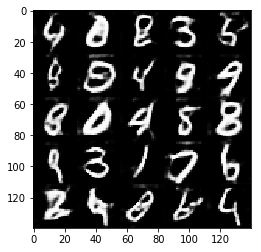

Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 2.5863
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.4086
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.1232
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.5721
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 2.4174
Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 2.1972
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 1.9423
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.7500
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.6560
Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 2.9170


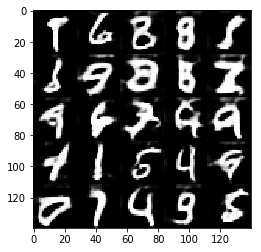

Epoch 2/2... Discriminator Loss: 0.4868... Generator Loss: 2.0704
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.6569
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 0.6688... Generator Loss: 1.9180
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 0.4738... Generator Loss: 2.5601
Epoch 2/2... Discriminator Loss: 0.4931... Generator Loss: 2.5030
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 2.4900
Epoch 2/2... Discriminator Loss: 0.5132... Generator Loss: 2.3370


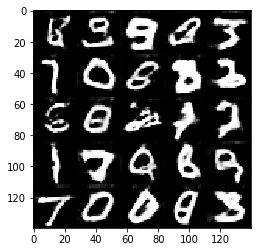

Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 2.0133
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 2.3318
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.4834
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.3594
Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 2.3247
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.1401
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 4.0552
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 1.3465


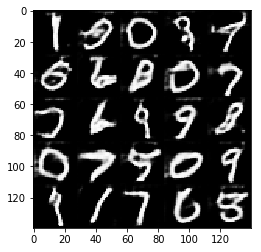

Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.6510
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.3778
Epoch 2/2... Discriminator Loss: 0.6368... Generator Loss: 1.9572
Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 2.0165
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 2.8982
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.6166
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 2.3739
Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 2.1459
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.7444


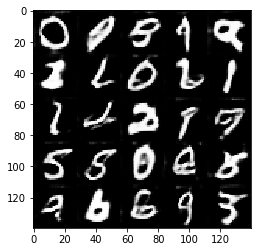

Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 3.7402
Epoch 2/2... Discriminator Loss: 0.6428... Generator Loss: 1.9200
Epoch 2/2... Discriminator Loss: 0.5638... Generator Loss: 2.0200
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 2.7647
Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 2.7859
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 2.0025
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.1301


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2415... Generator Loss: 7.2864
Epoch 1/1... Discriminator Loss: 3.0854... Generator Loss: 8.2396
Epoch 1/1... Discriminator Loss: 2.3546... Generator Loss: 5.5361
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 5.4725
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 2.5027
Epoch 1/1... Discriminator Loss: 1.9086... Generator Loss: 3.0671
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.4816


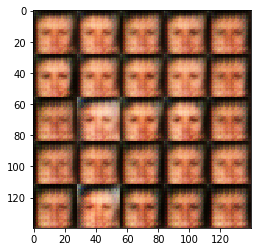

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 2.2310... Generator Loss: 0.2246
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.9323... Generator Loss: 0.2716
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 2.3432
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.6806


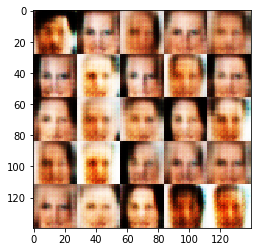

Epoch 1/1... Discriminator Loss: 1.9909... Generator Loss: 0.3250
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.7737... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.8552... Generator Loss: 2.8741
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8328


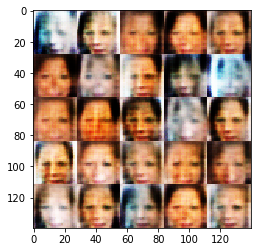

Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 1.8274... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 2.0818
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.8761


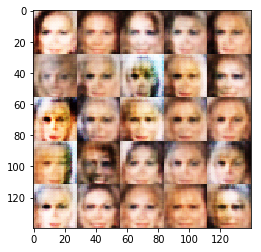

Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.6039
Epoch 1/1... Discriminator Loss: 1.6940... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 2.0170
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.2370


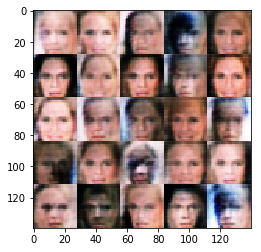

Epoch 1/1... Discriminator Loss: 1.6619... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 1.6195
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.0761


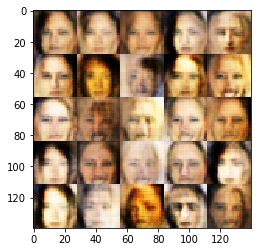

Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 1.5868
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.7752


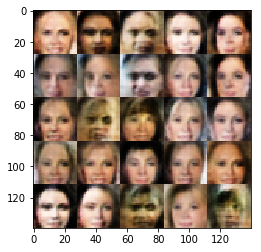

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 1.8976
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 2.1154
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 2.4245


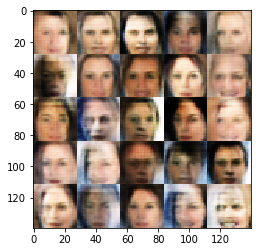

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 1.7325... Generator Loss: 1.9409
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.7324


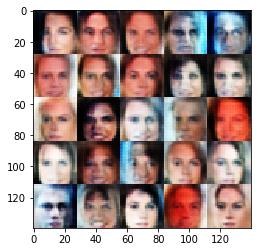

Epoch 1/1... Discriminator Loss: 1.6447... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.7363
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 2.0140... Generator Loss: 0.2824


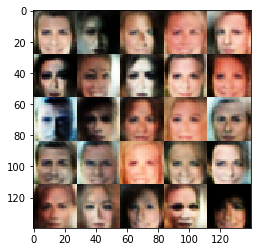

Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.2265


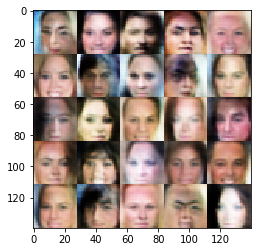

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.2172
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.5992


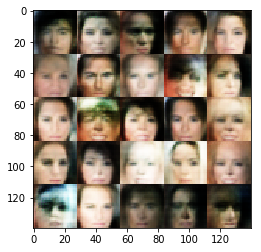

Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 2.4097
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6111


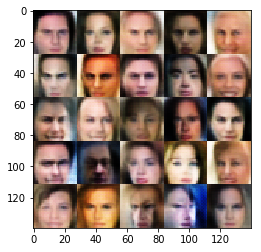

Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 2.2052
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6226


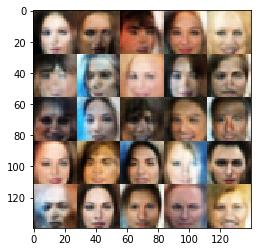

Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 2.0737
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.7196
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.5681


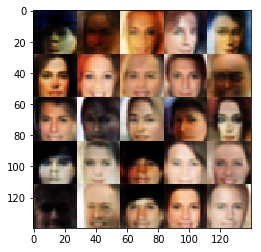

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.6855
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.6863


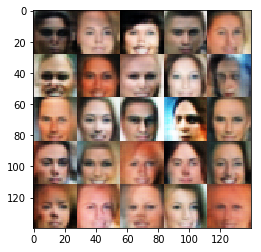

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.6373


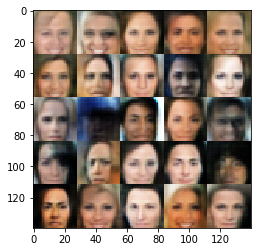

Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 2.1356
Epoch 1/1... Discriminator Loss: 2.1140... Generator Loss: 2.5150
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.7597


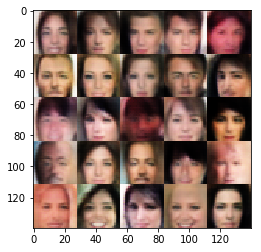

Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 2.5268... Generator Loss: 2.6721
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5496


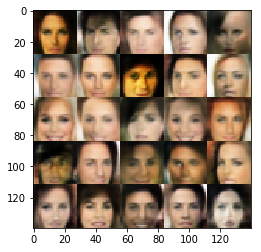

Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 2.2581... Generator Loss: 0.2192
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6109


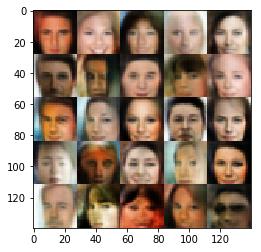

Epoch 1/1... Discriminator Loss: 1.9341... Generator Loss: 0.3774
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 2.1514
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.7218
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 2.4668


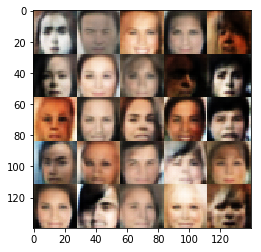

Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.9740
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 2.0762
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.5222


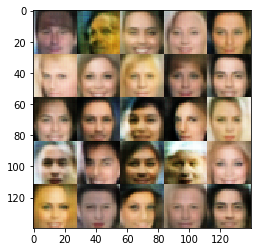

Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.0447


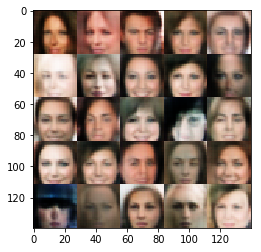

Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.9143
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8034


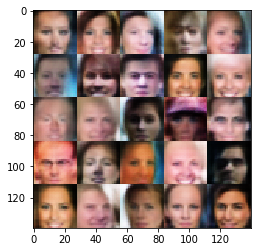

Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.9340
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 2.5249
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 2.3194


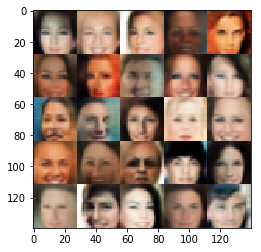

Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.8253
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 2.0183
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 2.8011
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 1.9898
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6492


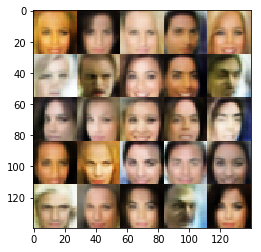

Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.4542
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 2.9256
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 2.3018
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 2.6640
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.9917


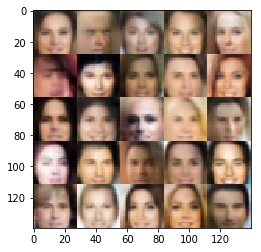

Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.7681
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 2.3930
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.8733
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 2.4596


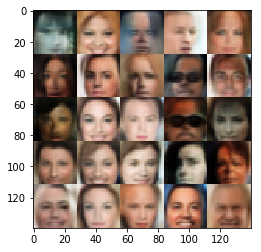

Epoch 1/1... Discriminator Loss: 2.1822... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 2.0642
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.3858


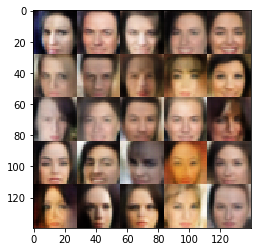

Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.5441
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 2.0215
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 2.5745
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.7485
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.9445


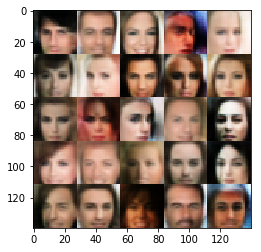

Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 2.5612
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 2.2145
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.9297


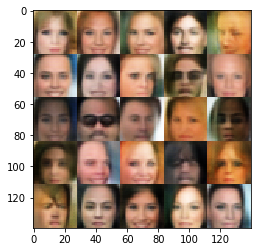

Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.9759
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1539


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.